# Path 2 – Training on Large Dataset

# 1. Introduction

This notebook presents the second modeling pipeline (Path 2) for spam detection, focusing on training machine learning models on a large-scale, real-world dataset. Unlike Path 1, which used a small, clean benchmark dataset, this pipeline aims to explore how models perform when trained on noisy, diverse, and more representative data.

The main objective of this path is to evaluate whether access to more data — even if noisier — can improve model robustness and generalization performance compared to small clean datasets. This approach simulates real-life scenarios where annotated data is abundant but less curated.

This notebook follows the same modular approach as Path 1, with key stages adapted for large-scale processing:

Data Loading and Preprocessing: Load a large external dataset with mixed-quality messages and apply consistent text cleaning.

Vectorization with TF-IDF: Generate high-dimensional sparse feature vectors using the same preprocessing and vectorization pipeline for comparability.

Model Training: Train the same two classifiers — Naive Bayes and Linear SVM — on the larger dataset.

Validation and Testing:

Evaluate models on a hold-out validation set.

Test generalization on the small clean dataset (used in Path 1) and the general dataset.

Real-World Prediction: Use the trained models to classify realistic messages to assess practical utility.

Result Summary and Comparison: Compare the models' performance in terms of accuracy and F1 score across all datasets.

This path provides critical insights into the trade-off between data quality and quantity. By contrasting the results from Path 1 and Path 2, we can better understand whether increasing data volume helps compensate for noise, and which model type adapts best to such conditions.



# 2. Setup

## 2.1 Install & Import Required Libraries Load Libraries and Settings

In [1]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# 3. Load Datasets



## 3.1 Dataset 2 – Large Dataset (Path 2 Training)







 – Large Combined SMS Dataset (from Kaggle) (Path 2 Training)
This dataset combines multiple SMS spam datasets and contains **about 10,000 messages**.  
It was created by *Tinu10kumar* and is available on Kaggle:  
[Kaggle Dataset Link](https://www.kaggle.com/datasets/tinu10kumar/sms-spam-dataset)  
**Role in project:** Used for training (in Path 2) and evaluation (in Path 1).

In [2]:
# Load Dataset 2 (Large Combined Dataset from Kaggle)
df_large = pd.read_csv("combined_dataset.csv")

df_large.head()

,target,text
0,spam,Congratulations! You've been selected for a lu...
1,spam,URGENT: Your account has been compromised. Cli...
2,spam,You've won a free iPhone! Claim your prize by ...
3,spam,Act now and receive a 50% discount on all purc...
4,spam,Important notice: Your subscription will expir...


## 3.2 Load Dataset 1 – Small Dataset
This dataset contains 5,574 SMS messages labeled as spam or ham.
It was used in the PyCon 2016 tutorial by justmarkham and is available on GitHub.

**Role in project:** Used for evaluation in Path 2.

In [3]:
# Load Dataset 1 (Small SMS Spam Dataset from GitHub)
url_small = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"

# Load with appropriate parameters
df_small = pd.read_csv(
    url_small,
    sep="\t",
    header=None,
    names=["label", "message"]
)

# Preview the first few rows
df_small.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 3.3 Dataset 3 – External Evaluation Dataset (Mendeley Data)

This dataset contains **SMS spam/ham messages** collected independently for research purposes.  
It is publicly available from Mendeley Data:  
[Mendeley Dataset Link](https://data.mendeley.com/datasets/f45bkkt8pr/1)  
**Role in project:** Used as a generalization test set in both paths.


In [4]:
# Load Dataset 3 (External Evaluation Dataset)
df_general = pd.read_csv("Dataset_5971.csv")

df_general.head()


,LABEL,TEXT,URL,EMAIL,PHONE
0,ham,Your opinion about me? 1. Over 2. Jada 3. Kusr...,No,No,No
1,ham,What's up? Do you want me to come online? If y...,No,No,No
2,ham,So u workin overtime nigpun?,No,No,No
3,ham,"Also sir, i sent you an email about how to log...",No,No,No
4,Smishing,Please Stay At Home. To encourage the notion o...,No,No,No


## 3.4 Dataset Overview and Basic Statistics

We explore the number of messages and spam/ham distribution in each dataset before cleaning.

### 3.4.1 Dataset 2 (Large)
Note: The original label column in this dataset is called "target". We'll rename it in the cleaning phase.


In [5]:
print(df_large.shape)
print(df_large['target'].value_counts())


(10961, 2)
target
ham     8555
spam    2406
Name: count, dtype: int64


### 3.4.2 Dataset 1 (Small)



In [6]:
print(df_small.shape)
print(df_small['label'].value_counts())

(5572, 2)
label
ham     4825
spam     747
Name: count, dtype: int64


### 3.4.3 Dataset 3 (General)
Note: This dataset uses "LABEL" for labels and "TEXT" for message content. These will be standardized later.


In [7]:
print(df_general.shape)
print(df_general['LABEL'].value_counts())

(5971, 5)
LABEL
ham         4844
Smishing     616
spam         466
Spam          23
smishing      22
Name: count, dtype: int64


# 4. Data Cleaning & Harmonization

In this section, we clean and unify the structure of all three datasets to ensure compatibility across both training paths.

## 4.1 Standardize Column Names
We ensure that all datasets have consistent structure: two columns named `label` and `message`,
with all labels in lowercase and harmonized across datasets.


### 4.1.1 Dataset 2 – Large (from Kaggle)
We rename the original columns `target` → `label` and `text` → `message`.
We also lowercase the labels to ensure consistency.


In [8]:
# Rename columns to match standard names
df_large = df_large.rename(columns={'target': 'label', 'text': 'message'})

# Keep only relevant columns
df_large = df_large[['label', 'message']]

# Normalize label values
df_large['label'] = df_large['label'].str.strip().str.lower()


### 4.1.2 Dataset 1 – Small
Standard column names are already defined when loading the dataset, but we normalize label values for consistency.


In [9]:
# Dataset 1 already has correct column names from initial load:
# df_small.columns = ['label', 'message']

# Normalize label values just in case
df_small['label'] = df_small['label'].str.strip().str.lower()

# No changes needed
df_small.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### 4.1.3 Dataset 3 – Generalization Test Set
We standardize the column names from `LABEL` and `TEXT` to `label` and `message`,
and unify label values such as `smishing` → `spam`.


In [10]:
# Rename and keep necessary columns
df_general = df_general[['LABEL', 'TEXT']]
df_general = df_general.rename(columns={'LABEL': 'label', 'TEXT': 'message'})
df_general['label'] = df_general['label'].str.strip().str.lower()
# Backup version with 'smishing' kept separately (optional)
df_general_with_smishing = df_general.copy()

# Convert all label types to unified 'spam'/'ham'
df_general['label'] = df_general['label'].replace({'smishing': 'spam'})


### 4.1.4 Check Types and Nulls
We verify that all datasets now have the correct types (`label`: string, `message`: string), and no missing values.


In [11]:
for name, df in zip(['Dataset 2', 'Dataset 1', 'Dataset 3'], [df_large, df_small, df_general]):
    print(f"--- {name} ---")
    print(df.dtypes)
    print("Null values:\n", df.isnull().sum())
    print("-" * 40)


--- Dataset 2 ---
label      object
message    object
dtype: object
Null values:
 label      0
message    0
dtype: int64
----------------------------------------
--- Dataset 1 ---
label      object
message    object
dtype: object
Null values:
 label      0
message    0
dtype: int64
----------------------------------------
--- Dataset 3 ---
label      object
message    object
dtype: object
Null values:
 label      0
message    0
dtype: int64
----------------------------------------


## 4.2 Remove Internal Duplicates
We identify and remove duplicate rows *within* each dataset individually before merging or cross-evaluation.


In [12]:
def check_and_remove_duplicates(df):
    """
    Checks for duplicate rows in the DataFrame.
    If found, prints counts before/after and removes them.
    Returns the cleaned DataFrame.
    """
    duplicate_count = df.duplicated().sum()

    if duplicate_count > 0:
        print(f"Number of duplicate rows: {duplicate_count}")
        print("\nMessage counts BEFORE removing duplicates:")
        print(df['label'].value_counts())
        print("Total rows BEFORE:", len(df))

        df = df.drop_duplicates()

        print("\nDuplicates removed.\n")
        print("Message counts AFTER removing duplicates:")
        print(df['label'].value_counts())
        print("Total rows AFTER:", len(df))

    else:
        print("No duplicates found.")
        print(df['label'].value_counts())
        print("Total rows:", len(df))

    return df


### 4.2.1 Apply to Dataset 2

In [13]:
print("\n>>> Dataset 2 (Large)")
df_large = check_and_remove_duplicates(df_large)


>>> Dataset 2 (Large)
Number of duplicate rows: 674

Message counts BEFORE removing duplicates:
label
ham     8555
spam    2406
Name: count, dtype: int64
Total rows BEFORE: 10961

Duplicates removed.

Message counts AFTER removing duplicates:
label
ham     8014
spam    2273
Name: count, dtype: int64
Total rows AFTER: 10287


### 4.2.2 Apply to Dataset 1

In [14]:
print(">>> Dataset 1 (Small)")
df_small = check_and_remove_duplicates(df_small)

>>> Dataset 1 (Small)
Number of duplicate rows: 403

Message counts BEFORE removing duplicates:
label
ham     4825
spam     747
Name: count, dtype: int64
Total rows BEFORE: 5572

Duplicates removed.

Message counts AFTER removing duplicates:
label
ham     4516
spam     653
Name: count, dtype: int64
Total rows AFTER: 5169


### 4.2.3 Apply to Dataset 3

In [15]:
print("\n>>> Dataset 3 (General Test)")
df_general = check_and_remove_duplicates(df_general)



>>> Dataset 3 (General Test)
Number of duplicate rows: 22

Message counts BEFORE removing duplicates:
label
ham     4844
spam    1127
Name: count, dtype: int64
Total rows BEFORE: 5971

Duplicates removed.

Message counts AFTER removing duplicates:
label
ham     4834
spam    1115
Name: count, dtype: int64
Total rows AFTER: 5949


## 4.3 Remove Overlapping Rows Between Datasets
To avoid data leakage and ensure fair evaluation, we remove overlapping rows between datasets
based on identical messages in the `message` column.


### 4.3.1 Remove rows from Dataset 1 that also exist in Dataset 2
We compare `message` columns and drop any duplicate messages from Dataset 1.
We will also check how the number of spam/ham messages has changed after removing duplicates.


In [16]:
# Before
counts_before_small = df_small['label'].value_counts()
print("Before removing overlaps with Dataset 2:")
print(f"Spam messages in Dataset 1: {counts_before_small.get('spam', 0)}")
print(f"Ham messages in Dataset 1: {counts_before_small.get('ham', 0)}")

# Remove overlapping rows from df_small
df_small_clean = df_small[~df_small['message'].isin(df_large['message'])].reset_index(drop=True)

# After removing
counts_after_small = df_small_clean['label'].value_counts()
print("\nAfter removing overlaps with Dataset 2:")
print(f"Spam messages in Dataset 1: {counts_after_small.get('spam', 0)}")
print(f"Ham messages in Dataset 1: {counts_after_small.get('ham', 0)}")

print(f"Total rows before removal: {len(df_small)}")
print(f"Total rows after removal: {len(df_small_clean)}")


Before removing overlaps with Dataset 2:
Spam messages in Dataset 1: 653
Ham messages in Dataset 1: 4516

After removing overlaps with Dataset 2:
Spam messages in Dataset 1: 228
Ham messages in Dataset 1: 328
Total rows before removal: 5169
Total rows after removal: 556


### 4.3.2 Remove rows from Dataset 3 that also exist in Dataset 1 or Dataset 2
After removing duplicates from Dataset 3, we'll check how the number of spam and ham messages have changed.


In [17]:
# Before removing
counts_before_general = df_general['label'].value_counts()
print("Before removing overlaps with Datasets 1 and 2:")
print(f"Spam messages in Dataset 3: {counts_before_general.get('spam', 0)}")
print(f"Ham messages in Dataset 3: {counts_before_general.get('ham', 0)}")

# Combine messages from Dataset 2 and cleaned Dataset 1
seen_messages = set(df_large['message']) | set(df_small_clean['message'])

# Remove overlapping messages from Dataset 3
df_general_clean = df_general[~df_general['message'].isin(seen_messages)].reset_index(drop=True)

# After Removing
counts_after_general = df_general_clean['label'].value_counts()
print("\nAfter removing overlaps with Datasets 1 and 2:")
print(f"Spam messages in Dataset 3: {counts_after_general.get('spam', 0)}")
print(f"Ham messages in Dataset 3: {counts_after_general.get('ham', 0)}")

print(f"Total rows before removal: {len(df_general)}")
print(f"Total rows after removal: {len(df_general_clean)}")



Before removing overlaps with Datasets 1 and 2:
Spam messages in Dataset 3: 1115
Ham messages in Dataset 3: 4834

After removing overlaps with Datasets 1 and 2:
Spam messages in Dataset 3: 559
Ham messages in Dataset 3: 589
Total rows before removal: 5949
Total rows after removal: 1148


# 5. Text Preprocessing

We clean and normalize the message texts to prepare them for vectorization.  
This includes:
- Lowercasing the text
- Replacing URLs and numbers with tokens (`URL_TOKEN`, `NUM_TOKEN`)
- Removing punctuation and extra spaces
- Lemmatization using NLTK
- Using a custom stopword list to **retain spam-indicative words** like `"won"`

Finally, we also convert the text labels (`ham` and `spam`) into **numerical labels** (`0` and `1`) required by machine learning models.


 ## 5.1 Setup

In [18]:
# Define standard stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define spam-indicative words to **keep**
important_words = {"won"}
custom_stop_words = stop_words - important_words  # Exclude important words from removal


## 5.2 Define the Preprocessing Function

In [19]:
def preprocess_text(text):
    """
    Preprocesses a single message:
    - Lowercases text
    - Replaces URLs with a token
    - Replaces numbers with a token
    - Removes punctuation
    - Lemmatizes each word
    - Removes stopwords (except custom important words)

    Returns cleaned text as a single string.
    """
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "URL_TOKEN", text)
    text = re.sub(r"\d+", "NUM_TOKEN", text)
    text = re.sub(r"[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub(r"\s+", " ", text).strip()

    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in custom_stop_words]
    return " ".join(words)


## 5.3 Apply Preprocessing to All Datasets

In [20]:
# Apply preprocessing to all datasets
df_large['clean_message'] = df_large['message'].apply(preprocess_text)
df_small_clean['clean_message'] = df_small_clean['message'].apply(preprocess_text)
df_general_clean['clean_message'] = df_general_clean['message'].apply(preprocess_text)


##5.4 Sample Output

In [21]:
# Show some examples
df_large[['message', 'clean_message']].head(5)

,message,clean_message
0,Congratulations! You've been selected for a lu...,congratulation youve selected luxury vacation ...
1,URGENT: Your account has been compromised. Cli...,urgent account compromised click reset passwor...
2,You've won a free iPhone! Claim your prize by ...,youve won free iphone claim prize clicking link
3,Act now and receive a 50% discount on all purc...,act receive NUMTOKEN discount purchase limited...
4,Important notice: Your subscription will expir...,important notice subscription expire soon rene...


## 5.5 Convert Labels to Numerical Format

To prepare the datasets for training, we convert the categorical labels ('ham', 'spam') into numerical values:  
- `ham` → `0`  
- `spam` → `1`  
This is necessary for most machine learning models that require numeric targets.


In [22]:
df_large['label_num'] = df_large['label'].map({'ham': 0, 'spam': 1})
df_small_clean['label_num'] = df_small_clean['label'].map({'ham': 0, 'spam': 1})
df_general_clean['label_num'] = df_general_clean['label'].map({'ham': 0, 'spam': 1})


# 6. Dataset Splitting

We split the cleaned and preprocessed dataset into training, validation, and test sets.  
This allows us to train models, tune hyperparameters, and evaluate generalization performance independently.

We use stratified sampling to ensure the **spam/ham distribution** remains consistent across splits:
- 70% training
- 15% validation
- 15% test


In [23]:
def split_data(X_text, y, test_size=0.3, val_ratio=0.5):
    """
    Splits the dataset into train/validation/test sets using stratified sampling.
    - test_size: portion of data held out for validation + test (e.g. 0.3)
    - val_ratio: ratio of validation to (validation + test) (e.g. 0.5 = 50/50 split)

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test
    """
    X_train, X_temp, y_train, y_temp = train_test_split(X_text, y, test_size=test_size, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_ratio, stratify=y_temp, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test


## Apply to Small Dataset

In [24]:
# Prepare inputs for splitting
X_large = df_large['clean_message']
y_large = df_large['label_num']

# Perform the split
X_text_train, X_text_val, X_text_test, y_train, y_val, y_test = split_data(X_large, y_large)

# Display sizes
print(f"Train size: {len(X_text_train)}")
print(f"Validation size: {len(X_text_val)}")
print(f"Test size: {len(X_text_test)}")


Train size: 7200
Validation size: 1543
Test size: 1544


In [25]:
print("Label distribution in train set:")
print(y_train.value_counts(normalize=True))

print("\nLabel distribution in validation set:")
print(y_val.value_counts(normalize=True))

print("\nLabel distribution in test set:")
print(y_test.value_counts(normalize=True))


Label distribution in train set:
label_num
0    0.779028
1    0.220972
Name: proportion, dtype: float64

Label distribution in validation set:
label_num
0    0.779002
1    0.220998
Name: proportion, dtype: float64

Label distribution in test set:
label_num
0    0.779145
1    0.220855
Name: proportion, dtype: float64


# 7. Vectorization Setup

We convert preprocessed text data into numerical features using **TF-IDF vectorization**.  
This transforms each message into a vector of word importance scores.

We use the following parameters:
- `max_features=3000`: to reduce dimensionality and avoid overfitting.

We fit the vectorizer **only on the training set** to avoid data leakage.

## 7.1 Vectorizer Definition

In [26]:
vectorizer = TfidfVectorizer(
    max_features=3000,  # Limit dimensionality
)

## 7.2 Apply TF-IDF Vectorizer

We transform each dataset into TF-IDF vectors using the `vectorizer` defined above.


### 7.2.1 Dataset 2 (Large – split into train/val/test)

In [27]:
X_train = vectorizer.fit_transform(X_text_train)
X_val = vectorizer.transform(X_text_val)
X_test = vectorizer.transform(X_text_test)

In [28]:
print("Shape of TF-IDF vectors (train):", X_train.shape)

Shape of TF-IDF vectors (train): (7200, 3000)


### 7.2.2 Dataset 1 (small – only transform)

In [29]:
X_small = vectorizer.transform(df_small_clean['clean_message'])
y_small= df_small_clean['label_num']

### 7.2.3 Dataset 3 (general – only transform)

In [30]:
X_general = vectorizer.transform(df_general_clean['clean_message'])
y_general= df_general_clean['label_num']

## optionally

In [31]:
print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Small dataset shape: {X_small.shape}")
print(f"General dataset shape: {X_general.shape}")


Train set shape: (7200, 3000)
Validation set shape: (1543, 3000)
Test set shape: (1544, 3000)
Small dataset shape: (556, 3000)
General dataset shape: (1148, 3000)


# 8. Model Training and Evaluation
We train and evaluate two classification models — Naive Bayes and Linear Support Vector Machine — using the dataset 2.
Evaluation is performed first on the validation set and then on the final test set. We report standard metrics such as accuracy, F1-score, and confusion matrix.


## 8.1 Define and Train Models

In [32]:
# Define models
models = {
    "NB-2": MultinomialNB(),   # Naive Bayes model
    "SVM-2": LinearSVC()       # Linear Support Vector Machine model
}

# Store trained models
trained_models = {}

print(" Evaluating Models on Validation Set")
for name, model in models.items():
    print(f"\n=== {name} ===")

    # Train the model on the training dataset
    model.fit(X_train, y_train)

    # Save the trained model
    trained_models[name] = model

    # Predict on the validation set
    y_val_pred = model.predict(X_val)

    # Calculate evaluation metrics
    acc_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred)
    cm_val = confusion_matrix(y_val, y_val_pred)

    # Display evaluation results
    print(f"Validation Accuracy: {acc_val:.4f}")
    print(f"Validation F1 Score: {f1_val:.4f}")
    print("Validation Confusion Matrix:\n", cm_val)
    print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

 Evaluating Models on Validation Set

=== NB-2 ===
Validation Accuracy: 0.9391
Validation F1 Score: 0.8554
Validation Confusion Matrix:
 [[1171   31]
 [  63  278]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1202
           1       0.90      0.82      0.86       341

    accuracy                           0.94      1543
   macro avg       0.92      0.89      0.91      1543
weighted avg       0.94      0.94      0.94      1543


=== SVM-2 ===
Validation Accuracy: 0.9494
Validation F1 Score: 0.8781
Validation Confusion Matrix:
 [[1184   18]
 [  60  281]]
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      1202
           1       0.94      0.82      0.88       341

    accuracy                           0.95      1543
   macro avg       0.95      0.90      0.92      1543
weighted avg       0.95      0.95      

## 8.2 Final Evaluation on Test Set
After selecting models based on validation performance, we report final evaluation metrics on the unseen test set.


In [33]:
for name, model in trained_models.items():
    print(f"\n=== {name} (Final Test Evaluation) ===")
    y_test_pred = model.predict(X_test)

    acc_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    print(f"Test Accuracy: {acc_test:.4f}")
    print(f"Test F1 Score: {f1_test:.4f}")
    print("Confusion Matrix:\n", cm_test)
    print("Classification Report:\n", classification_report(y_test, y_test_pred))



=== NB-2 (Final Test Evaluation) ===
Test Accuracy: 0.9301
Test F1 Score: 0.8338
Confusion Matrix:
 [[1165   38]
 [  70  271]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      1203
           1       0.88      0.79      0.83       341

    accuracy                           0.93      1544
   macro avg       0.91      0.88      0.89      1544
weighted avg       0.93      0.93      0.93      1544


=== SVM-2 (Final Test Evaluation) ===
Test Accuracy: 0.9514
Test F1 Score: 0.8876
Confusion Matrix:
 [[1173   30]
 [  45  296]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1203
           1       0.91      0.87      0.89       341

    accuracy                           0.95      1544
   macro avg       0.94      0.92      0.93      1544
weighted avg       0.95      0.95      0.95      1544



# 9. Evaluation on External Datasets

To assess the generalization ability of our trained models, we evaluate them on two external datasets:
- **Dataset 1:** Cleaned version of the smaller dataset.
- **Dataset 3:** Manually created general dataset.


## 9.1 Evaluate on Clean Small Dataset

In [34]:
print("\n Evaluating Pretrained Models on Dataset 1(Clean Small Dataset)")

for name, model in trained_models.items():
    print(f"\n=== {name} on Dataset 1 ===")
    y_small_pred = model.predict(X_small)

    acc_2nd = accuracy_score(y_small, y_small_pred)
    f1_2nd = f1_score(y_small, y_small_pred)
    cm_2nd = confusion_matrix(y_small, y_small_pred)

    print(f"Accuracy: {acc_2nd:.4f}")
    print(f"F1 Score: {f1_2nd:.4f}")
    print("Confusion Matrix:\n", cm_2nd)
    print("Classification Report:\n", classification_report(y_small, y_small_pred))



 Evaluating Pretrained Models on Dataset 1(Clean Small Dataset)

=== NB-2 on Dataset 1 ===
Accuracy: 0.9532
F1 Score: 0.9398
Confusion Matrix:
 [[327   1]
 [ 25 203]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       328
           1       1.00      0.89      0.94       228

    accuracy                           0.95       556
   macro avg       0.96      0.94      0.95       556
weighted avg       0.96      0.95      0.95       556


=== SVM-2 on Dataset 1 ===
Accuracy: 0.9712
F1 Score: 0.9640
Confusion Matrix:
 [[326   2]
 [ 14 214]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       328
           1       0.99      0.94      0.96       228

    accuracy                           0.97       556
   macro avg       0.97      0.97      0.97       556
weighted avg       0.97      0.97      0.97       556



## 9.2 Evaluate on General Dataset

In [35]:
print("\n Evaluating Pretrained Models on 3rd Dataset (General Dataset)")

for name, model in trained_models.items():
    print(f"\n=== {name} on 3rd Dataset ===")
    y_pred = model.predict(X_general)

    acc_gen = accuracy_score(y_general, y_pred)
    f1_gen = f1_score(y_general, y_pred)
    cm_gen = confusion_matrix(y_general, y_pred)

    print(f"Accuracy: {acc_gen:.4f}")
    print(f"F1 Score: {f1_gen:.4f}")
    print("Confusion Matrix:\n", cm_gen)
    print("Classification Report:\n", classification_report(y_general, y_pred))



 Evaluating Pretrained Models on 3rd Dataset (General Dataset)

=== NB-2 on 3rd Dataset ===
Accuracy: 0.8885
F1 Score: 0.8745
Confusion Matrix:
 [[574  15]
 [113 446]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       589
           1       0.97      0.80      0.87       559

    accuracy                           0.89      1148
   macro avg       0.90      0.89      0.89      1148
weighted avg       0.90      0.89      0.89      1148


=== SVM-2 on 3rd Dataset ===
Accuracy: 0.9094
F1 Score: 0.9000
Confusion Matrix:
 [[576  13]
 [ 91 468]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.98      0.92       589
           1       0.97      0.84      0.90       559

    accuracy                           0.91      1148
   macro avg       0.92      0.91      0.91      1148
weighted avg       0.92      0.91      0.91      1148



### 9.3 Save Trained Models and Vectorizer

To facilitate future use — such as batch predictions, deployment in production, or further experimentation — we save the trained models and the TF-IDF vectorizer using `joblib`. This ensures consistency between the training pipeline and downstream inference.


In [36]:

# Save Naive Bayes model
joblib.dump(trained_models["NB-2"], "nb2_model.pkl")

# Save SVM model
joblib.dump(trained_models["SVM-2"], "svm2_model.pkl")

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer_path2.pkl")

print(" Models and vectorizer saved successfully.")


 Models and vectorizer saved successfully.


# 10. Predicting New Messages

We now test the trained models on unseen, realistic messages to simulate a real-world spam filtering scenario. First, we load the saved models and vectorizer, then classify new messages using the same preprocessing and vectorization steps as during training.


## 10.1 Load Saved Models and Vectorizer for Prediction

In [37]:
# Load saved models
trained_models = {
    "NB-2": joblib.load("nb2_model.pkl"),
    "SVM-2": joblib.load("svm2_model.pkl")
}

# Load the saved TF-IDF vectorizer
vectorizer = joblib.load("tfidf_vectorizer_path2.pkl")

# Define classification function
def classify_message(msg, model=trained_models["NB-2"]):
    cleaned = preprocess_text(msg)
    vector = vectorizer.transform([cleaned])
    prediction = model.predict(vector)[0]
    return "Spam" if prediction else "Legitimate"


## 10.2 Real-World Test Messages

In [38]:

test_messages = [
    # Likely Spam
    "URGENT! Your account has been locked. Verify your identity at http://fakebanklogin.com now.",
    "Win a brand new iPhone 15! Just reply YES to enter the contest.",
    "You have received a cash reward of $2000. Claim here: rewardz.co/claim",
    "Congratulations! You've been selected for a free cruise to the Bahamas.",

    # Likely Ham (legitimate)
    "Don’t forget your doctor’s appointment tomorrow at 10am.",
    "Are we still on for dinner this Friday night?",
    "Here's the PDF for the meeting agenda. Let me know if you have any questions.",
    "Thanks for your payment. Your subscription has been renewed."
]

# 11.3 Classify Each Message Using All Models
for msg in test_messages:
    print(f"\n Test Message: {msg}")
    for name, model in trained_models.items():
        label = classify_message(msg, model=model)
        print(f"{name} Prediction: {label}")



 Test Message: URGENT! Your account has been locked. Verify your identity at http://fakebanklogin.com now.
NB-2 Prediction: Spam
SVM-2 Prediction: Spam

 Test Message: Win a brand new iPhone 15! Just reply YES to enter the contest.
NB-2 Prediction: Spam
SVM-2 Prediction: Spam

 Test Message: You have received a cash reward of $2000. Claim here: rewardz.co/claim
NB-2 Prediction: Spam
SVM-2 Prediction: Spam

 Test Message: Congratulations! You've been selected for a free cruise to the Bahamas.
NB-2 Prediction: Spam
SVM-2 Prediction: Spam

 Test Message: Don’t forget your doctor’s appointment tomorrow at 10am.
NB-2 Prediction: Legitimate
SVM-2 Prediction: Legitimate

 Test Message: Are we still on for dinner this Friday night?
NB-2 Prediction: Legitimate
SVM-2 Prediction: Legitimate

 Test Message: Here's the PDF for the meeting agenda. Let me know if you have any questions.
NB-2 Prediction: Legitimate
SVM-2 Prediction: Legitimate

 Test Message: Thanks for your payment. Your subscriptio

# 11. Result Summary

In this section, we summarize and compare the performance of the two models — Naive Bayes (NB-2) and Support Vector Machine (SVM-2) — across four evaluation datasets. We report both accuracy and F1 score metrics, and visualize the results to support interpretation.


## 11.1 Comparison of Model Performance

In [39]:
# Collect model performance results
results = {
    "Dataset": ["Validation Set", "Test Set", "Small Dataset", "General Dataset"],
    "NB-2 Accuracy": [],
    "SVM-2 Accuracy": [],
    "NB-2 F1": [],
    "SVM-2 F1": []
}

# Evaluate and append results
def evaluate_and_append(model, X, y):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred), f1_score(y, y_pred)

# Loop over datasets
datasets_eval = [
    ("Validation Set", X_val, y_val),
    ("Test Set", X_test, y_test),
    ("Small Dataset", X_small, y_small),
    ("General Dataset", X_general, y_general)
]

for label, X_eval, y_eval in datasets_eval:
    nb_acc, nb_f1 = evaluate_and_append(trained_models["NB-2"], X_eval, y_eval)
    svm_acc, svm_f1 = evaluate_and_append(trained_models["SVM-2"], X_eval, y_eval)

    results["NB-2 Accuracy"].append(nb_acc)
    results["SVM-2 Accuracy"].append(svm_acc)
    results["NB-2 F1"].append(nb_f1)
    results["SVM-2 F1"].append(svm_f1)

# Convert to DataFrame
results_df = pd.DataFrame(results)
display(results_df)


,Dataset,NB-2 Accuracy,SVM-2 Accuracy,NB-2 F1,SVM-2 F1
0,Validation Set,0.939080,0.949449,0.855385,0.878125
1,Test Set,0.930052,0.951425,0.833846,0.887556
2,Small Dataset,0.953237,0.971223,0.939815,0.963964
3,General Dataset,0.888502,0.909408,0.874510,0.900000


In [40]:
# Save results to CSV for later combination
results_df.to_csv("results_path2.csv", index=False)

## 11.2 Visualization of Performance Comparison

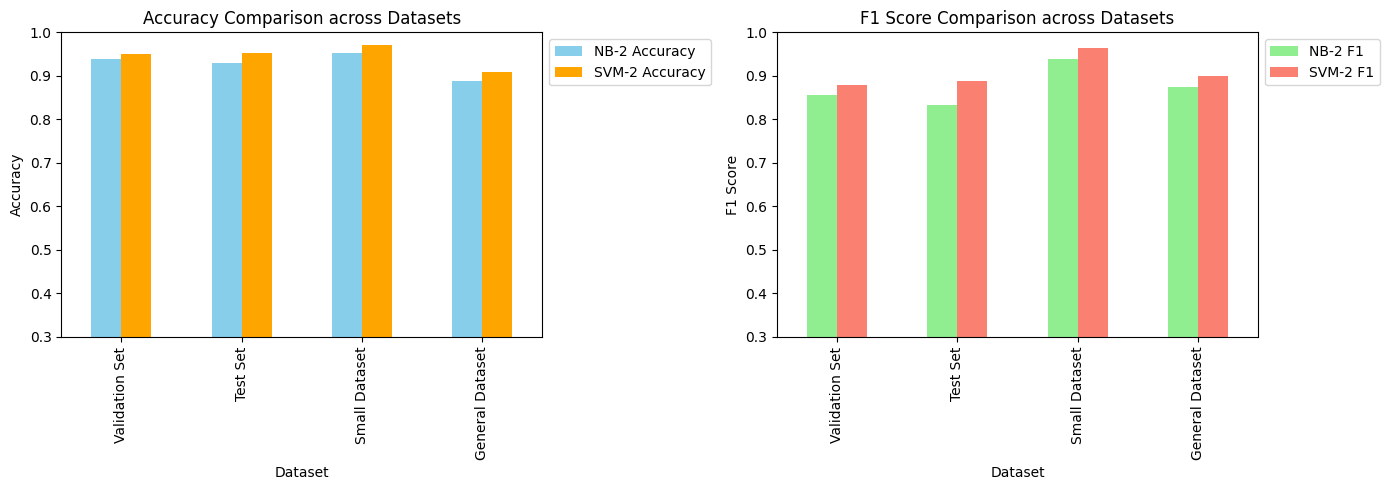

In [41]:
# 12.2 Visualization of Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy plot
results_df.plot(x="Dataset", y=["NB-2 Accuracy", "SVM-2 Accuracy"], kind="bar", ax=axes[0],
                color=["skyblue", "orange"], legend=False)
axes[0].set_title("Accuracy Comparison across Datasets")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0.3, 1.0)
axes[0].legend(["NB-2 Accuracy", "SVM-2 Accuracy"], loc='upper left', bbox_to_anchor=(1.0, 1.0))

# F1 score plot
results_df.plot(x="Dataset", y=["NB-2 F1", "SVM-2 F1"], kind="bar", ax=axes[1],
                color=["lightgreen", "salmon"], legend=False)
axes[1].set_title("F1 Score Comparison across Datasets")
axes[1].set_ylabel("F1 Score")
axes[1].set_ylim(0.3, 1.0)
axes[1].legend(["NB-2 F1", "SVM-2 F1"], loc='upper left', bbox_to_anchor=(1.0, 1.0))

plt.tight_layout()
plt.show()


# 12. Which Model Performed Better in Path 2?
The evaluation results across the validation set, final test set, and two external datasets (Dataset 1 and Dataset 3) clearly indicate that the SVM-2 model outperformed NB-2 in nearly all aspects.

On the validation set, SVM-2 achieved a higher F1 score (0.8781 vs. 0.8554), reflecting better balance between precision and recall.

This trend continued on the final test set, where SVM-2 not only reached superior accuracy (0.9514 vs. 0.9301) but also demonstrated more reliable spam detection, with an F1 score of 0.8876 compared to 0.8338 for NB-2.

The generalization capability of SVM-2 was further confirmed through evaluations on Dataset 1 and Dataset 3.

On Dataset 1, SVM-2 achieved a remarkable F1 score of 0.9640, surpassing NB-2's already strong 0.9398. On the more challenging and distributionally diverse Dataset 3, SVM-2 again led with an F1 score of 0.9000, compared to 0.8745 for NB-2.

In conclusion, **SVM-2** consistently showed higher performance across all datasets, highlighting its robustness, generalization ability, and effectiveness for spam classification when trained on a larger, more representative dataset in Path 2.


---

## Additional Note:

In Section **11. Predicting New Messages**, both NB-2 and SVM-2 were able to correctly classify real-world spam and legitimate messages. However, SVM-2’s stronger metrics suggest it is more reliable for real-world deployment scenarios.
